# 548 hw7 solution

# Kalman filter

(a) *Implement the Kalman filter for a discrete-time, linear time-varying, finite-horizon estimation problem.*

***Hint:*** since you will need this for both Homework and Project, I suggest the following structure:

**Solution:**

In [1]:
# Imports
import numpy as np
import numpy.linalg as la
import scipy.linalg as sla
import matplotlib.pyplot as plt
import pdb
%matplotlib inline

In [2]:
def kalman_filter(x0,P0,A,B,ut,C,Q,R,t_,z_):
  """
  input:
    x0 - d x 1 array; initial state mean
    P0 - d x d array; initial state covariance
    A - func : t -> d x d array; state transition
    B - func : t -> d x m array; control input matrix
    u - func : t -> m x 1 array; control input
    C - func : t -> n x d array; observation matrix
    Q - func : t -> m x m array; input disturbance covariance
    R - func : t -> n x n array; output disturbance covariance
    t_ - N array; times
    z_ - l x N array; noisy observations

  output:
    x_ - d x N array; state estimate
    P_ - d x d x N array; state estimate covariance
  """
  x_ = [x0]; _x = [x0]; P_ = [P0]
  for t,zt in zip(t_,z_):
    # State Propagation and prediction
    t_idx = int(t)-1
    # pdb.set_trace()
    xt_ = np.dot(A(t_idx),x_[-1]) + np.dot(B(t_idx),ut(t_idx))
    Pt_ = np.dot(A(t_idx), np.dot(P_[-1], A(t_idx).T)) + Q(t_idx)

    # Update
    K = np.dot(np.dot(Pt_, C(t_idx).T), la.inv(R(t_idx) + np.dot(np.dot(C(t_idx), Pt_), C(t_idx).T)))
    xt = xt_ + np.dot(K,(zt - np.dot(C(t_idx), xt_)))
    KC = np.eye(A(t_idx).shape[0]) - np.dot(K,C(t_idx))
    Pt = np.dot(np.dot(KC, Pt_), KC.T) + np.dot(np.dot(K,R(t_idx)),K.T)

    # Modified the output to include the model predicted state
    _x.append(xt_)
    x_.append(xt)
    P_.append(Pt)
  return np.hstack(_x),np.hstack(x_),np.dstack(P_)

(b) *How would you test your Kalman filter?  This is an open-ended question -- there is no one single right answer; list as many tests as you can think of.*

**Solution:**

Some ways to test the Kalman filter:

1) Compare the output of the implemented Kalman filter to that of other students' or Kalman filter implemented using other packages. Since most packages use the steady-state Kalman filter as compared to our implemented time-varying Kalman filter, we can compare the Kalman gain obtained at the end of our Kalman filter implementation to that returned by a Kalman filter implementation from other packages. 

2) Test Kalman filter on a simple linear stable system with random noise introduced to the input and/or output using known covariances. The Kalman filter works if the state and measurment errors computed is a Gaussian noise with the known covariances. This can be tested using statistical tools or plotting a histogram of these errors to see if it follows a Gaussian distribution. 

3) Ideally for a linear system, we can substitute the input and output disturbance, that is state and measurement errors, into the least sqaure estimate formular and differentiate w.r.t. the state. This should be equal to zero when optimal. We can then evaluate this expression from the results obtained using the implemented Kalman filter to see if we get zero.

4) Since the Kalman gain is the optimal estimate, we can apply a perturbation to the Kalman gain at every time step and show that the optimal gain gives the best estimate compared to the perturbed gain.


(c) *Perform one of the tests you suggested in (b) and provide summary statistics or plots that convince you the test passed.*

**Solution:**

For a given stable discrete linear system (borrowed from Matlab):

$A = 
\left[\begin{array}{c} 1.1269 & -0.4940 \\ 1.0 & 0\end{array}\right],$ 
$\quad B = 
\left[\begin{array}{c} -0.3832 \\ 0.5919 \end{array}\right], $
and
$\quad C = 
\left[\begin{array}{c} 1 & 0\end{array}\right]$

with covariances $Q = 
\left[\begin{array}{c} 0.01 & 0 \\ 0 & 0.02 \end{array}\right],$ and R = [0.1]




In [3]:
A = np.asarray([[1.1269, -0.4940], [1.0, 0.0]])
B = np.asarray([[-0.3832],[0.5919]])
C = np.asarray([[1.0, 0.0]])
Q = np.asarray([[0.01, 0.0], [0.0, 0.02]])
R = np.asarray([[0.1]])

n_in = A.shape[0]
n_out = C.shape[0]
n_sim = 1000
tspan = np.arange(n_sim)
u = np.sin(tspan/5)

U,D,V = la.svd(Q, full_matrices=True)
D_root = np.diag(np.sqrt(D)) 
L_Q = np.dot(V, D_root)

U,D,V = la.svd(R, full_matrices=True)
D_root = np.diag(np.sqrt(D)) 
L_R = np.dot(V, D_root)
x_init = np.zeros((n_in,1))

x_, x_true, z_, delta_, eta_ = [], [], [], [], []
x_.append(x_init)
x_true.append(x_init)
np.random.seed(30)
for t_idx in range(n_sim):
  # pdb.set_trace()
  delta = np.dot(L_Q, (np.random.multivariate_normal(np.zeros(n_in), np.eye(n_in), 1).T))
  eta = np.dot(L_R, (np.random.multivariate_normal(np.zeros(n_out), np.eye(n_out), 1).T))
  _x = np.dot(A, x_true[-1]) + np.dot(B, u[t_idx]) # Actual signal without noise
  x_next = np.dot(A, x_[-1]) + np.dot(B, u[t_idx]) + delta # Noisy state signal
  zt = np.dot(C, x_[-1]) + eta # Noisy measurement

  x_.append(x_next)
  x_true.append(_x)
  z_.append(zt)
  delta_.append(delta)
  eta_.append(eta)

x_ = np.asarray(x_) # Noisy state
x_true = np.asarray(x_true) # True state
z_ = np.squeeze(np.asarray(z_)) # Noisy measurement
delta_ = np.asarray(delta_)
eta_ = np.asarray(eta_)

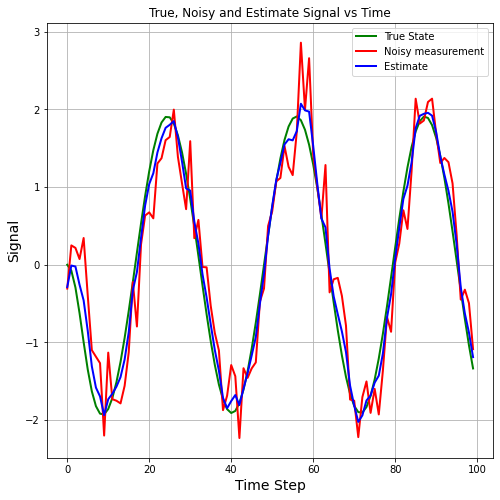

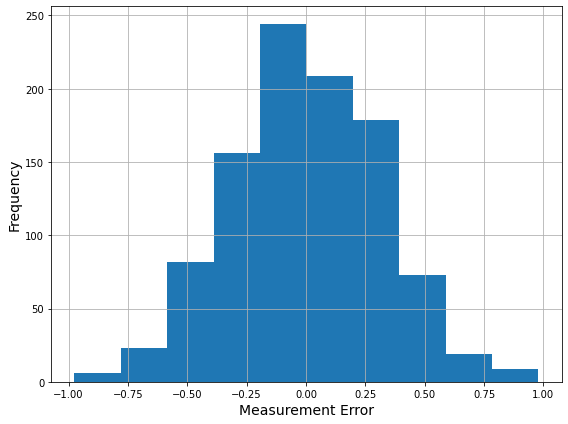

In [4]:
# Obtain estimate from implemented Kalman filter
A_ = lambda t: A
B_ = lambda t: B
C_ = lambda t: C
R_ = lambda t: R
Q_ = lambda t: Q
ut = lambda t: u[t]

mu0 = np.zeros((n_in,1))  # Initial condition on the state
sigma0 = np.eye(n_in)    # Initial error covariance

x_pred, x_hat, P_hat = kalman_filter(mu0, sigma0, A_, B_, ut, C_, Q_, R_, tspan + 1, z_)

# Plot of errors vs time
# plotting only a portion of data for clarity
plt.figure(figsize=(8,8));
plt.plot(x_true[1:101,0], 'g', linewidth = 2,label=r'True State')
plt.plot(z_[0:100], 'r', linewidth = 2, label=r'Noisy measurement')
plt.plot(x_hat[0,1:101], 'b', linewidth = 2, label=r'Estimate')
plt.title(r'True, Noisy and Estimate Signal vs Time')
plt.ylabel(r'Signal',fontsize=14)
plt.xlabel(r'Time Step',fontsize=14)
plt.legend()
plt.grid()

# Histogram of measurement error
plt.figure(figsize=(8,6));
n_bins = 10
plt.hist(z_ - x_hat[0,1:], bins=n_bins)
plt.ylabel(r'Frequency',fontsize=14)
plt.xlabel(r'Measurement Error',fontsize=14)
plt.tight_layout()
plt.grid()

We can observe that the implemented Kalman filter is able to estimate the true signal from the noisy measurement. Also from the histogram of the noisy measurement, the error distribution is Gaussian.

To validate optimality, we will use the test 4 in (b) above. In order to maintain the structure of Kalman filter function above, we will instead apply the perturbation to the system matrix A which will implicitly perturb the Kalman gain.

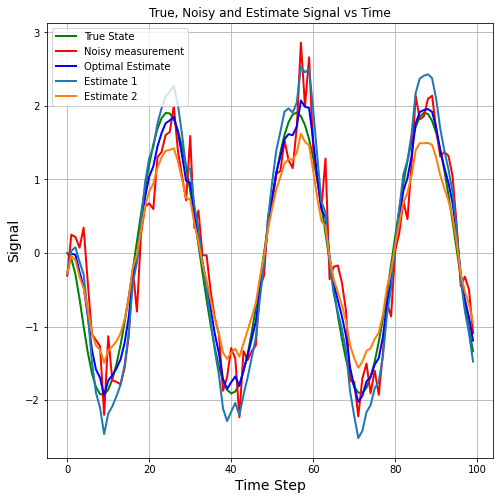

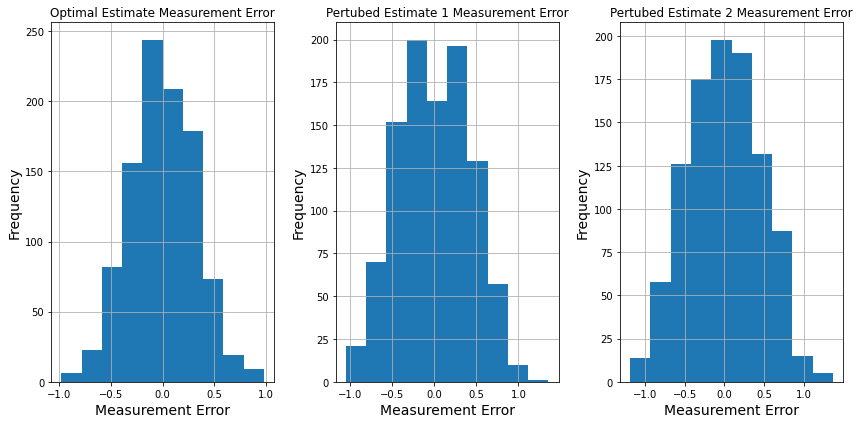

In [5]:
A_1 = lambda t: np.asarray([[1.1269, -0.4940], [1.0, 0.0]]) + 0.2 * np.eye(n_in)
A_2 = lambda t: np.asarray([[1.1269, -0.4940], [1.0, 0.0]]) - 0.2 * np.eye(n_in)

_, x_hat_1, _ = kalman_filter(mu0, sigma0, A_1, B_, ut, C_, Q_, R_, tspan + 1, z_)
_, x_hat_2, _ = kalman_filter(mu0, sigma0, A_2, B_, ut, C_, Q_, R_, tspan + 1, z_)

# Plot of errors vs time
# plotting only a portion of data for clarity
plt.figure(figsize=(8,8));
plt.plot(x_true[1:101,0], 'g', linewidth = 2,label=r'True State')
plt.plot(z_[0:100], 'r', linewidth = 2, label=r'Noisy measurement')
plt.plot(x_hat[0,1:101], 'b', linewidth = 2, label=r'Optimal Estimate')
plt.plot(x_hat_1[0,1:101], linewidth = 2, label=r'Estimate 1')
plt.plot(x_hat_2[0,1:101], linewidth = 2, label=r'Estimate 2')
plt.title(r'True, Noisy and Estimate Signal vs Time')
plt.ylabel(r'Signal',fontsize=14)
plt.xlabel(r'Time Step',fontsize=14)
plt.legend()
plt.grid()

# Histogram of errors
plt.figure(figsize=(12,6));
n_bins = 10
ax = plt.subplot(1,3,1)
plt.hist(z_ - x_hat[0,1:], bins=n_bins)
plt.ylabel(r'Frequency',fontsize=14)
plt.xlabel(r'Measurement Error',fontsize=14)
plt.title(r'Optimal Estimate Measurement Error')
plt.tight_layout()
plt.grid()

ax = plt.subplot(1,3,2)
plt.hist(z_ - x_hat_1[0,1:], bins=n_bins)
plt.ylabel(r'Frequency',fontsize=14)
plt.xlabel(r'Measurement Error',fontsize=14)
plt.title(r'Pertubed Estimate 1 Measurement Error')
plt.tight_layout()
plt.grid()

ax = plt.subplot(1,3,3)
plt.hist(z_ - x_hat_2[0,1:], bins=n_bins)
plt.ylabel(r'Frequency',fontsize=14)
plt.xlabel(r'Measurement Error',fontsize=14)
plt.title(r'Pertubed Estimate 2 Measurement Error')
plt.tight_layout()
plt.grid()


It can be observed from the above figures that of all the estimates computed, the optimal estimate is the one that is closest to the true signal and its error distributions is the closest to a normal distribution. We can therefore conclude that not only does our Kalman filter work as expected, it also returns the optimal estimate.

In the remainder of this problem, you'll apply your Kalman filter to [this dataset](https://raw.githubusercontent.com/sburden/548-20sp/master/548_20sp_hw7tuz.csv); the first column is time, the next column contains the input, and the last column contains the position measurement.

Here's a code snippet to load the data into a numpy array:

In [6]:
url = 'https://raw.githubusercontent.com/sburden/548-20sp/master/548_20sp_hw7tuz.csv'
import pandas as pd
import numpy as np
data = np.asarray(pd.read_csv(url,header=None))


The system that generated the data has nonlinear dynamics given by
$$ml^2\ddot{a} = -mlg \sin(a) + \tau$$
where $a$ is pendulum angle, $l$ is rod length, $m$ is pendulum mass, $g$ is force due to gravity, and $\tau$ is an input torque arising from a motor attached to the rod at its pivot point.  An encoder measures the angle of the rod about its pivot point.

(d) *Linearize the system about its stable equilibrium, making use of the following parameters.  Specify the (CT-LTI) system $A$, $B$, $C$ matrices.*

In [7]:
g,length,mass = 9.81,.5,1. # m/sec^2, m, kg

**Solution:**

Writing dynamics in first order form:
$$f(a, \dot{a}) = \left[\begin{array}{c} \dot{a} \\ \ddot{a}\end{array}\right] = \left[\begin{array}{c} \dot{a} \\ -\frac{g}{l} \sin(a) + \frac{1}{ml^2} \tau \end{array}\right]$$

Linearizing about the equilibrium $(a, \dot{a}) = (0, 0$ results in:

$$A 
= 
\left[\begin{array}{c} \frac{\delta f_1}{\delta a} &  \frac{\delta f_1}{\delta \dot{a}}\\ \frac{\delta f_2}{\delta a} &  \frac{\delta f_2}{\delta \dot{a}} \end{array}\right] 
=
\left[\begin{array}{c} 0 &  1\\ -\frac{g}{l} & 0 \end{array}\right]
=
\left[\begin{array}{c} 0 &  1\\ -19.62 & 0 \end{array}\right]
$$

and

$$B
= 
\left[\begin{array}{c} \frac{\delta f_1}{\delta u} \\ \frac{\delta f_2}{\delta u} \end{array}\right] 
= 
\left[\begin{array}{c} 0 \\ \frac{1}{ml^2} \end{array}\right]
= 
\left[\begin{array}{c} 0 \\ 4 \end{array}\right]$$

Since the encoder measures the angle of the rod about its pivot point:
$$C
= 
\left[\begin{array}{c} 1 & 0 \end{array}\right]$$

(e) *Perform exact discretization with stepsize $\Delta = .1$ sec. Specify the (DT-LTI) system $\bar{A}, \bar{B}, \bar{C}$ matrices.*

**Solution:**

Exact discritization can be obtained using:
$$\bar{A} = e^{A \Delta}$$

$$\bar{B} = (\bar{A} - I) A^{-1} B$$

$$\bar{C} = C$$


In [8]:
g,length,mass = 9.81,.5,1. # m/sec^2, m, kg
delta = 0.1
A = np.asarray([[0.0,1.0],[-g/length,0.0]])
B = np.asarray([[0.0],[1/(mass*length**2)]])
C = np.asarray([[1.0, 0.0]])
A_d = sla.expm(A * delta)
B_d = np.dot(np.dot(A_d - np.eye(A.shape[0]), la.inv(A)), B)
C_d = C
print(f'A_bar = {A_d}')
print(f'B_bar = {B_d}')
print(f'C_bar = {C_d}')

A_bar = [[ 0.90349348  0.09676193]
 [-1.89846905  0.90349348]]
B_bar = [[0.01967513]
 [0.38704772]]
C_bar = [[1. 0.]]


The variance in the angle measurement is $.1$ rad, and the variance in the actuator torque is $.2$ Nm.

(f) *Specify the covariance matrices $Q$, $R$ you'll pass to your Kalman filter function from (a).*

**Solution:**

Variance in the angle measurement results in $R = [0.1]$ while the variance in the actuator torque results in $Q = \left[\begin{array}{c} 0 & 0\\ 0 &  0.2 \end{array}\right] $

(g) *Apply your Kalman filter function from (a) starting from the  initial state distribution specified by the following mean and covariance.  Plot the state and measurement errors versus time, and plot a histogram of the error measurement statistics (in ``matplotlib``, use ``plt.hist``).*

**Solution:**

In [9]:
mu0 = [[-0.14415834],[ 0.23380803]]
Sigma0 = [[ 0.1, 0. ],[ 0., 1. ]]

t_, u_, z_ = data[:,0], data[:,1], data[:,2] 

A_ = lambda t: A_d
B_ = lambda t: B_d
C_ = lambda t: C_d
# Assume the Q and R given are in discrete form
R_ = lambda t: np.array([[0.1]])
Q_ = lambda t: np.asarray([[0.0,0.0],[0.0,0.2]])
ut = lambda t: u_[t]

x_pred, x_hat, P_hat = kalman_filter(mu0,Sigma0,A_,B_,ut,C_,Q_,R_,t_,z_)

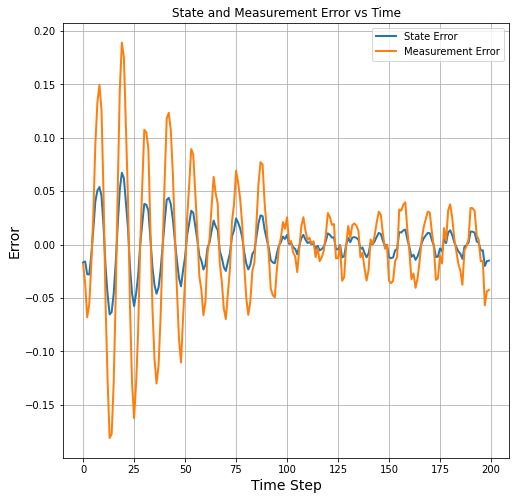

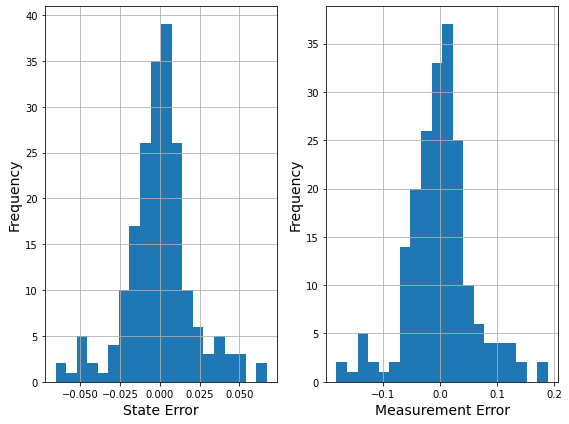

In [10]:
st_err = x_hat[0,1:] - x_pred[0,1:]
meas_err = z_ - x_hat[0,1:]

# Plot of errors vs time
plt.figure(figsize=(8,8));
plt.plot(st_err, linewidth=2, label=r'State Error')
plt.plot(meas_err, linewidth=2, label=r'Measurement Error')
plt.title(r'State and Measurement Error vs Time')
plt.ylabel(r'Error',fontsize=14)
plt.xlabel(r'Time Step',fontsize=14)
plt.legend()
plt.grid()

# Histogram of errors
plt.figure(figsize=(8,6));
ax = plt.subplot(1,2,1)
n_bins = 20
plt.hist(st_err, bins=n_bins)
plt.ylabel(r'Frequency',fontsize=14)
plt.xlabel(r'State Error',fontsize=14)
plt.tight_layout()
plt.grid()

ax = plt.subplot(1,2,2)
n_bins = 20
plt.hist(meas_err, bins=n_bins)
plt.ylabel(r'Frequency',fontsize=14)
plt.xlabel(r'Measurement Error',fontsize=14)
plt.tight_layout()
plt.grid()

***Bonus:*** use gradient descent to numerically verify that the state estimate returned by your Kalman filter minimizes the (recursive) least-squares objective function.  (Note that the [Kalman / Rauch–Tung–Striebel *smoother*](https://en.wikipedia.org/wiki/Kalman_filter#Minimum-variance_smoother), which we haven't covered in lecture, provides the solution to the (non-recursive) least-squares problem posed over the entire sequence of measurements -- to obtain the same solution as the Kalman filter, you need to structure the objective function so that the state estimate at time $t$ is only determined by measurements from time $0$ to $t$.)